In [103]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as pylab
import cv2
import glob,os
from PIL import Image as im
import imageio
from tqdm import tqdm
import skimage
from skimage import io
from skimage import color
import skimage.filters
from skimage.filters import median
from skimage.morphology import disk
from skimage import exposure
from skimage.feature import canny
from skimage.filters import sobel
from skimage.transform import hough_line, hough_line_peaks
from skimage.draw import polygon
#import pydicom as dicom
from PIL import Image

class PreProcess:

    def __init__(self,img_path):
      #self.original_image =  io.imread(img_path)
      self.original_image  =cv2.imread(img_path)
      #self.original_image = self.original_image.astype(np.uint8)
      #self.gray_image = color.rgb2gray(self.original_image)
      #self.gray_image = cv2.cvtColor(self.original_image, cv2.COLOR_BGR2GRAY)
      self.gray_image = cv2.imread(img_path,0)
      print('Original image')
      plt.imshow(self.original_image)
      plt.show()
      print('Gray image')
      plt.imshow(self.gray_image)
      plt.show()

    def apply_artifact_removal(self,image):
        hh,ww = self.gray_image.shape[:2]
        #gray_image = self.gray_image.astype(np.uint8)
        gray_image = self.gray_image
        print("IMAGE SHAPE 2 : ",gray_image.shape)
        print(hh,ww)
        thresh = cv2.threshold(gray_image,0,255,cv2.THRESH_OTSU)[1] 
    
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
        morph = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)

        contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]
        big_contour = max(contours, key=cv2.contourArea)

        mask = np.zeros((hh,ww), dtype=np.uint8)
        cv2.drawContours(mask, [big_contour], 0, 255, cv2.FILLED)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (55,55))
        mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)

        artifact_removed_image = cv2.bitwise_and(image, image, mask=mask)
    
        print("ARTIFACT DONE BOIS")
        print('Artifact removed image')
        plt.imshow(artifact_removed_image)
        plt.show()

        return artifact_removed_image
    
    def apply_resize_image(self,image):
        #resized_image = color.gray2rgb(image)
        resized_image = cv2.resize(image, (256, 256))
        
        print('Resized image')
        plt.imshow(resized_image,cmap='gray')
        plt.show()
        return resized_image
        
    def apply_crop_image(self,image):
        image_copy = np.copy(image) 
        img_grey = image_copy
        img_grey = img_grey.astype(np.uint8)
        img_grey = cv2.cvtColor(img_grey, cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(img_grey, 0 , 255, cv2.THRESH_BINARY)[1]
        print('Thresh : ', thresh.shape) 
        x, y, w, h = cv2.boundingRect(thresh) #find the bounding rectangle of nonzero points in the image
        print("XYWH values : ",x,y,w,h)

        cropped_image = image_copy[y:y+h, x:x+w,:]
        print('Cropped image')
        plt.imshow(cropped_image)
        plt.show()

        return cropped_image

    def right_orient_mammogram(self,image):
        left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
        right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])
        
        if(left_nonzero < right_nonzero):
            image = cv2.flip(image, 1)

        return image
    
    def apply_canny_sobel(self,image):
        canny_image = canny(image, 3.05) #this value works with 90-95% of the images
        return sobel(canny_image)

    def get_hough_lines(self,canny_image):
        h, theta, d = hough_line(canny_image)
        lines = list()
        print('\nAll hough lines')
        for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
            print("Angle: {:.2f}, Dist: {:.2f}".format(np.degrees(angle), dist))
            x1 = 0
            y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
            x2 = canny_image.shape[1]
            y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
            lines.append({
                'dist': dist,
                'angle': np.degrees(angle),
                'point1': [x1, y1],
                'point2': [x2, y2]
            })
    
        return lines

    def shortlist_hough_lines(self,lines):
        MIN_ANGLE = 10
        MAX_ANGLE = 70
        MIN_DIST  = 5
        MAX_DIST  = 256
    
        shortlisted_lines = [x for x in lines if 
                            (x['dist']>=MIN_DIST) &
                            (x['dist']<=MAX_DIST) &
                            (x['angle']>=MIN_ANGLE) &
                            (x['angle']<=MAX_ANGLE)
                            ]
        print('\nShorlisted lines')
        for i in shortlisted_lines:
            print("Angle: {:.2f}, Dist: {:.2f}".format(i['angle'], i['dist']))
        
        return shortlisted_lines
    
    def remove_pectoral(self,shortlisted_lines):
        shortlisted_lines.sort(key = lambda x: x['dist'])
        pectoral_line = shortlisted_lines[0]
        d = pectoral_line['dist']
        theta = np.radians(pectoral_line['angle'])
    
        x_intercept = d/np.cos(theta)
        y_intercept = d/np.sin(theta)
    
        return polygon([0, 0, y_intercept], [0, x_intercept, 0])
    
        
    def pectoral_removed(self,image):
        image = image.astype(np.uint8)
        gray_img = color.rgb2gray(image) #changed
        
        right_orient_img = self.right_orient_mammogram(gray_img)
        equ_image = exposure.equalize_hist(right_orient_img)

        canny_image = self.apply_canny_sobel(equ_image)
        lines = self.get_hough_lines(canny_image)
        shortlisted_lines = self.shortlist_hough_lines(lines)        
        rr, cc = self.remove_pectoral(shortlisted_lines)
        try:
            right_orient_img[rr,cc] = 0
        except Exception as e:
            return e

        print('Pectoral Removed image')
        plt.imshow(right_orient_img)
        plt.show()

        return right_orient_img

    def remove_graypx(self,image):
        binary_mask = image > 80
        restored = image.copy()
        restored[~binary_mask] = 0

        print('Gray pixel removed image')
        plt.imshow(restored,cmap='gray')
        plt.show()

        return restored
    
    
    def padding(self,image):
        image = image.astype(np.uint8)
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        old_image_h, old_image_w, channels = image.shape
        new_image_h = 256
        new_image_w = 256
        colour = (0,0,0)
        result_image = np.full((new_image_h,new_image_w,channels),colour,dtype=np.uint8)
  
        #center offset
        x_center = (new_image_w - old_image_w) // 2
        y_center = (new_image_h - old_image_h) // 2

        #copy image into center of resultant image
        result_image[y_center:y_center + old_image_h, x_center:x_center + old_image_w] = image  

        #resize image to 256x256
        padded_resized = cv2.resize(result_image, (256, 256))

        print('Padded image')
        plt.imshow(padded_resized,cmap='gray')
        plt.show()

        return padded_resized

    def apply_clahe(self,image):
        clahe = cv2.createCLAHE(clipLimit = 5)
        clahe_image = image.astype(np.uint8)
        clahe_image = cv2.cvtColor(clahe_image,cv2.COLOR_BGR2GRAY)
        clahe_image = clahe.apply(clahe_image) + 0
        return clahe_image

    def dcm2png(self,img_path):
        ds = dicom.dcmread(img_path)
        new_image = ds.pixel_array.astype(float)
        scaled_image = (np.maximum(new_image, 0) / new_image.max()) * 255.0
        return scaled_image
      
    def pgm2png(self,img_path):
        filename='p1'
        new_file = "{}.png".format(filename)
        dump_path = '/content/drive/MyDrive/Dont_change_this_name_ffs/'
        with Image.open(img_path) as im:
            im.save(dump_path+new_file)
        
        result = cv2.imread(dump_path+new_file)
        return result

    def run(self,img_path):
        img = cv2.imread(img_path)
        artiless_img = self.apply_artifact_removal(img)
        print("Artifact removed shape: ",artiless_img.shape)
        resize_img = self.apply_resize_image(artiless_img)
        print('Resized image shape: ',resize_img.shape)
        crop_img = self.apply_crop_image(resize_img)
        print('Crop image shape: ',crop_img.shape)
        result_img = self.pectoral_removed(crop_img)
        print('Pectoral removed image shape : ',result_img.shape)
        nongray_img = self.remove_graypx(255*result_img)
        print('Gray pixel removed image shape : ',nongray_img.shape)
        final_img = self.padding(nongray_img)
        print('Padded image shape',final_img.shape)
        complete_preprocess_image = self.apply_clahe(final_img) 
        print('Complete Preprocessed image shape',complete_preprocess_image.shape)
        print('Result of PreProcessing')
        plt.imshow(complete_preprocess_image,cmap='gray')
        plt.show()
        return complete_preprocess_image

Original image


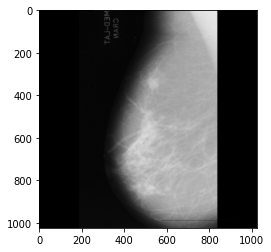

Gray image


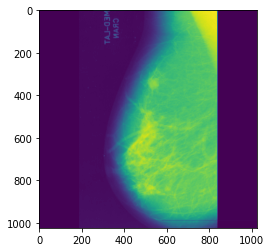

IMAGE SHAPE 2 :  (1024, 1024)
1024 1024
ARTIFACT DONE BOIS
Artifact removed image


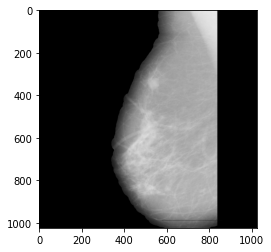

Artifact removed shape:  (1024, 1024, 3)
Resized image


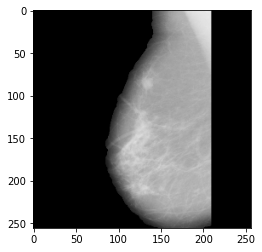

Resized image shape:  (256, 256, 3)
Thresh :  (256, 256)
XYWH values :  85 0 125 256
Cropped image


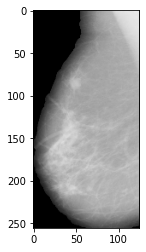

Crop image shape:  (256, 125, 3)

All hough lines
Angle: -0.50, Dist: 0.50
Angle: 26.65, Dist: 30.55
Angle: -13.58, Dist: 58.60
Angle: -23.63, Dist: 29.55
Angle: 9.55, Dist: 39.57
Angle: 75.92, Dist: 134.74

Shorlisted lines
Angle: 26.65, Dist: 30.55
Pectoral Removed image


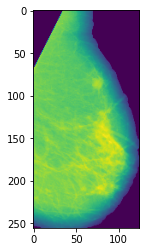

Pectoral removed image shape :  (256, 125)
Gray pixel removed image


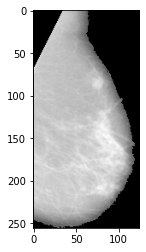

Gray pixel removed image shape :  (256, 125)
Padded image


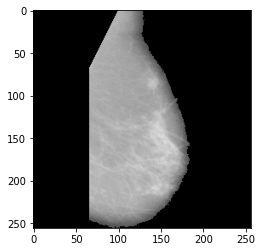

Padded image shape (256, 256, 3)
Complete Preprocessed image shape (256, 256)
Result of PreProcessing


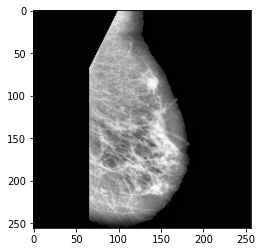

In [108]:
#img_path = '/content/drive/MyDrive/Dont_change_this_name_ffs/1-1.dcm'
#img_path = '/content/drive/MyDrive/Dont_change_this_name_ffs/mdb003.pgm'
img_path = '/content/drive/MyDrive/MINI_MIAS/malignant_cases/mdb023.png'
prep_obj = PreProcess(img_path)
img = prep_obj.run(img_path)